# **Apple leaf disease discovery with Deep Learning and Keras using a Plant Pathology dataset from Kaggle**

Apples are one of the most important temperate fruit crops in the world. Leaf diseases can be a large problem for apple orchards because the diseased plants can have direct repercussions on the number of apples that can be produced and the quality of those apples.  Currrently, apple leaf diseases are discovered by manual labor which can take considerable amounts of time that can be used for production and raise labor costs.

Leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging pose significant limitations to plant disease classification and identification with computer vision models.  A deep learning model using Keras will be developed and trained on part of the training data and subsequently tested on a smaller part of the training data as the Kaggle test set is has only three images.  The Keras model will attempt to classify a given leaf image from the newly created test dataset to a particular disease category.  An effective model could also be used in other plant pathology environments as well and potentially improve plant quality of life as well as fruit quality and labor costs.



### **Loading the data from Kaggle**

Loading data from Kaggle takes a fine tuned approach as demonstrated below. First, the Kaggle API Client must be installed.

In [1]:
# Install the Kaggle API client.
!pip install -q kaggle

Next, the following cell must be ran whereby a kaggle.json file will be uploaded from the Kaggle account settings page.

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"superingram","key":"9a2d29590dfcd0da2b23ff4fca0cee7c"}'}

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Apr 28 07:25 kaggle.json


This code is very important as you cannot download files from folders on Kaggle without it.

In [5]:
# This code will allow folders to be imported from Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=0618b305549ade646f6fb30753a6b0276e62b1e1dad7d63b4382fdb39cc18cde
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


The Kaggle API client expects this file to be in the Kaggle directory ~/.kaggle,

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

This permissions change avoids a warning on Kaggle tool startup.

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

Now, the Kaggle data can be downloaded to Google Colab PRO

In [8]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [03:40<00:00, 78.3MB/s]
100% 14.9G/14.9G [03:40<00:00, 72.5MB/s]


Important imported python packages

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications.xception import preprocess_input

Finally, the Kaggle plant pathology zip files can be unzipped and uploaded for analysis. The .zip file will ultimately be deleted after unzipping and the capture command allows us to hide 5000 listed files.

In [10]:
# unzipping the zipped file and deleting the zipped file
%%capture
!unzip \*.zip && rm *.zip 

The training set images will have to be formatted, resized and reduced as there is not enough RAM for all 18000 images.  10240 of the original images will be used as the training set and coordinated with the 'train/csv' file. The resulting set of images will be called "trainset."

In [11]:
# The training images will be formatted and resized.  
# The training set with images will have to be reduced as the RAM will not read in all 18000 images.
# A new test set will be created from some of the remaining training images.

root = '/content/train_images'
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [299, 299])
    img = tf.cast(img, tf.uint8)
    return img.numpy()

df = pd.read_csv('/content/train.csv')[:10240]

df['image'] = [os.path.join(root, x) for x in df['image']]

trainset = []
for x in (df['image']):
    trainset.append(load_image(x))

### **Exploratory Data Analysis**

In [ ]:
df.shape

(10240, 2)

In [ ]:
df.head(21)

,image,labels
0,/content/train_images/800113bb65efe69e.jpg,healthy
1,/content/train_images/8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,/content/train_images/80070f7fb5e2ccaa.jpg,scab
3,/content/train_images/80077517781fb94f.jpg,scab
4,/content/train_images/800cbf0ff87721f8.jpg,complex
5,/content/train_images/800edef467d27c15.jpg,healthy
6,/content/train_images/800f85dc5f407aef.jpg,rust
7,/content/train_images/801d6dcd96e48ebc.jpg,healthy
8,/content/train_images/801f78399a44e7af.jpg,complex
9,/content/train_images/8021b94d437eb7d3.jpg,healthy


In [ ]:
df.describe()

,image,labels
count,10240,10240
unique,10240,12
top,/content/train_images/c4d60bf3969035e9.jpg,scab
freq,1,2706


The shape of the dataframe is to be expected as here is where the labels will come from.  The summary above states that there are 12 unique labels.  The first 21 labels of the dataframe was displayed to show all of the potential disease categories. 

In [ ]:
df['labels'].unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

Below is a visualization of the occurrence of different types of disease in the training set using the seaborn package.  The labels are not evenly distributed.  More importantly, some labels consist of spaces with will be a problem for a deep neural network.  Only six of the most common diseases will be used since the other labels look to be conglomerations of other diseases.

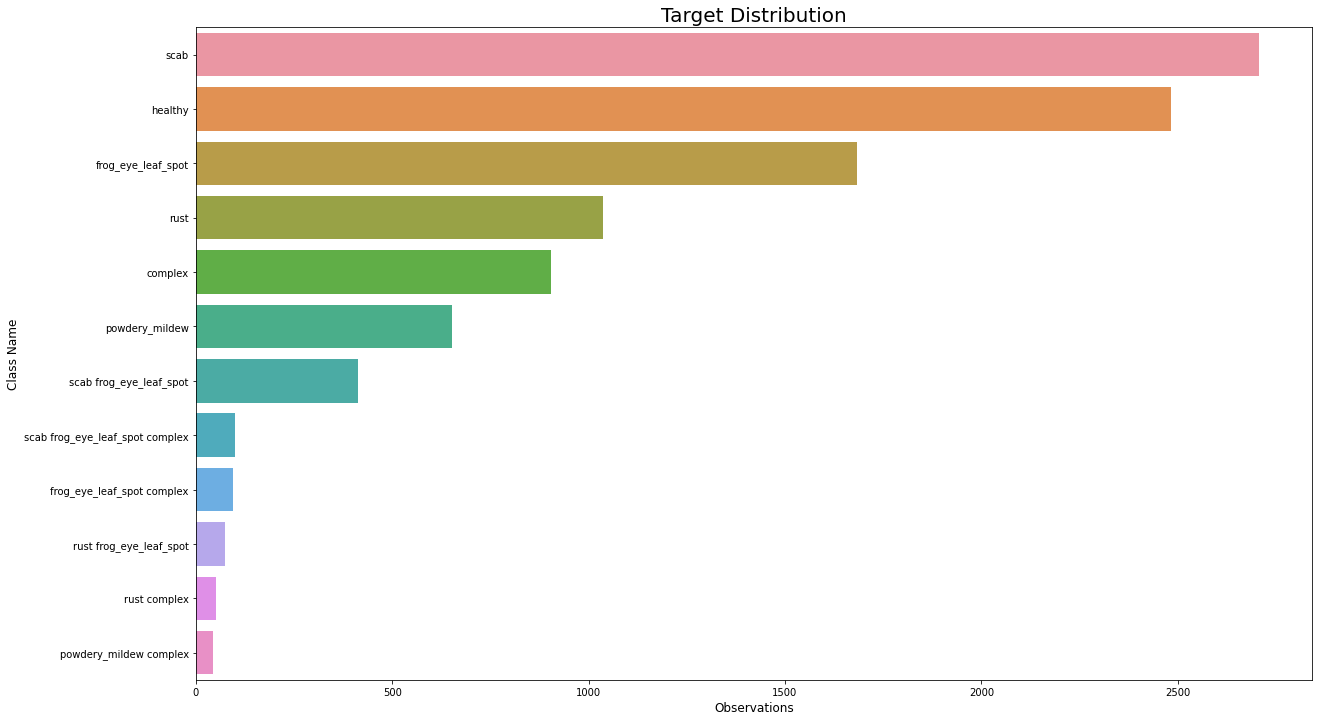

In [ ]:
targets=df.labels.value_counts()
fig = plt.figure(figsize=(20,12))
sns.barplot(y=targets.sort_values(ascending=False).index, x=targets.sort_values(ascending=False).values)
plt.title('Target Distribution', size = 20)
plt.xlabel("Observations", size=12)
plt.ylabel("Class Name", size=12)
plt.show()

The test images will be read into an array for display since there is only three.

In [ ]:
folders = glob.glob('/content/test_images*')
image_names = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        image_names.append(f)

test_images = []        
for image in image_names:
    test_images.append(cv2.imread(image))
    

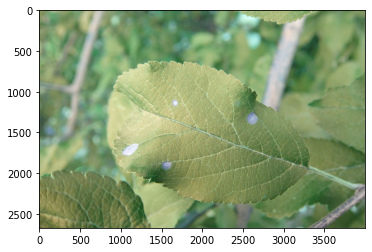

In [ ]:
# Displaying the first test image.
plt.imshow(test_images[0])

The first image has a length of 2672 and a width of 4000 with a depth of three channels indicating a color image.

In [ ]:
test_images[0].shape

(2672, 4000, 3)

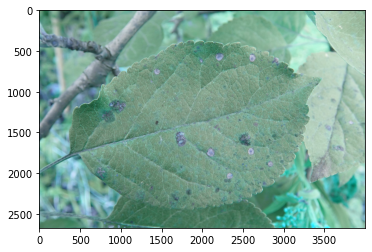

In [ ]:
# Displaying the second test image.
plt.imshow(test_images[1])

The second image has the same length, width and depth as the second.

In [ ]:
test_images[1].shape

(2672, 4000, 3)

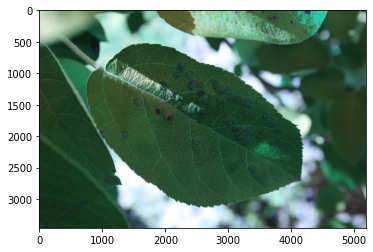

In [ ]:
# Displaying the third test image.
plt.imshow(test_images[2])

The third image has a length of 3456 and a width of 5184 !

In [ ]:
test_images[2].shape

(3456, 5184, 3)

### **A little bit of Feature Engineering and Data Wrangling**

A class will be creaded to compare labels against as only the six most relevant classes of disease will be used. 

In [12]:
plt.style.use('fivethirtyeight')

class BDI:
    
    root = '/content/train_images'
    classes = [
        'complex', 
        'frog_eye_leaf_spot', 
        'powdery_mildew', 
        'rust', 
        'scab',
        'healthy']
    strategy = tf.distribute.get_strategy()
    batch_size = 16


The MultiLabelBinarizer is used to remove whitespace in the labels and create a format usable for a Keras neural network model.

In [13]:
df.set_index('image', inplace=True)

init_labels = df['labels'].values.copy()

df['labels'] = [x.split(' ') for x in df['labels']]
labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(df['labels'].values)

train = pd.DataFrame(columns=BDI.classes, data=labels, index=df.index)

train.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/800113bb65efe69e.jpg,0,0,0,0,0,1
/content/train_images/8002cb321f8bfcdf.jpg,1,1,0,0,1,0
/content/train_images/80070f7fb5e2ccaa.jpg,0,0,0,0,1,0
/content/train_images/80077517781fb94f.jpg,0,0,0,0,1,0
/content/train_images/800cbf0ff87721f8.jpg,1,0,0,0,0,0


The dataframe still has 10240 rows and now, 6 columns.

In [ ]:
train.describe

<bound method NDFrame.describe of                                             complex  ...  healthy
image                                                ...         
/content/train_images/800113bb65efe69e.jpg        0  ...        1
/content/train_images/8002cb321f8bfcdf.jpg        1  ...        0
/content/train_images/80070f7fb5e2ccaa.jpg        0  ...        0
/content/train_images/80077517781fb94f.jpg        0  ...        0
/content/train_images/800cbf0ff87721f8.jpg        1  ...        0
...                                             ...  ...      ...
/content/train_images/c6a634cbb08a6dcb.jpg        0  ...        0
/content/train_images/c6a69190e5fc2576.jpg        0  ...        0
/content/train_images/c6aed22d906bb523.jpg        0  ...        0
/content/train_images/c6af7edb2f912001.jpg        0  ...        0
/content/train_images/c6b214c2ac455f3f.jpg        0  ...        1

[10240 rows x 6 columns]>

This is what the training images will look like to humans but not necessarily to a computer.

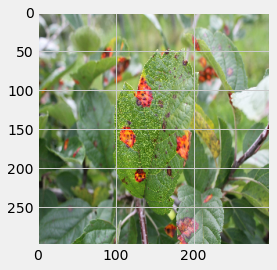

In [ ]:
plt.imshow(trainset[400].reshape(299, 299, 3))

A test set will now be created from the training set using the same methods so that there are plenty of images to predict.  

In [14]:
tester = pd.read_csv('/content/train.csv')[10241:12800]

tester['image'] = [os.path.join(root, x) for x in tester['image']]

test_set = []
for x in (tester['image']):
    test_set.append(load_image(x))

The MultiLabelBinarizer is used again remove whitespace in our labels for the test set.

In [15]:
tester.set_index('image', inplace=True)

test_init_labels = tester['labels'].values.copy()

tester['labels'] = [x.split(' ') for x in tester['labels']]
test_labels = MultiLabelBinarizer(classes=BDI.classes).fit_transform(tester['labels'].values)

test = pd.DataFrame(columns=BDI.classes, data=test_labels, index=tester.index)

test.head()

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
/content/train_images/c6b460353d77c362.jpg,0,0,0,0,1,0
/content/train_images/c6b4b491f27e4349.jpg,1,0,0,0,0,0
/content/train_images/c6b50cf4bd087374.jpg,0,0,0,0,1,0
/content/train_images/c6b833780fe5c34a.jpg,1,0,0,0,0,0
/content/train_images/c6bc9352f4466627.jpg,0,0,0,0,0,1


Dimensionality reduction

In [16]:
trainset = np.array(trainset)

In [17]:
test_set = np.array(test_set)

Final inspection of the data

In [18]:
trainset.shape

(10240, 299, 299, 3)

In [19]:
test_set.shape

(2559, 299, 299, 3)

In [ ]:
labels.shape

(10240, 6)

In [ ]:
test_labels.shape

(2559, 6)

The shape of the train set and test set with their respective labels are as they should be.

### **The Keras convolutional neural network (CNN)**

In [ ]:
# Initializes a sequential CNN model
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(8, kernel_size=3, activation='relu', 
               input_shape=(224, 224, 1), padding = 'same'))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Add another convolutional layer
model.add(Conv2D(16, kernel_size=3, activation='relu'))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Add a third convolutional layer
model.add(Conv2D(32, kernel_size=3, activation='relu'))

# Add batch normalization layer
model.add(BatchNormalization())

# Add a pooling layer
model.add(MaxPool2D(2))

# Add a dropout layer
model.add(Dropout(0.5))

# Flatten the output of the last convolutional layer
model.add(Flatten())

# Add one last dense layer
model.add(Dense(64, activation='sigmoid'))

# Output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
           loss='categorical_crossentropy', 
           metrics=['accuracy'])


This CNN consists of three convolutional layers, a dense hidden layer and an output layer.  Relu activation is utiilized with an 'adam' optimizer.  Each convolutional layer has a kernel size of 3 and is followed by batch normalization, max pooling of 2 and a drop out layer with a value of 0.5 since padding was not utilized. The model was flattened after the last convolutional layer.

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 8)       80        
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 8)       32        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 110, 110, 16)      1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 55, 55, 16)       

In [ ]:
# Fit the model
model.fit(trainset, labels, validation_split=0.2, epochs=3, batch_size=20, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/3
410/410 [==============================] - 5s 12ms/step - loss: 1.7886 - accuracy: 0.2832 - val_loss: 1.8561 - val_accuracy: 0.3091
Epoch 2/3
410/410 [==============================] - 4s 10ms/step - loss: 1.6746 - accuracy: 0.3491 - val_loss: 1.8833 - val_accuracy: 0.3037
Epoch 3/3
410/410 [==============================] - 4s 10ms/step - loss: 1.6340 - accuracy: 0.3711 - val_loss: 1.7711 - val_accuracy: 0.3369


In [ ]:
# Evaluate the model
model.evaluate(test_set, test_labels, batch_size=10)

256/256 [==============================] - 1s 3ms/step - loss: 1.7664 - accuracy: 0.3337


[1.7664055824279785, 0.33372411131858826]

The validation accuracy is very low because the convolutional neural network needs more data than we can provide due to memory limitations.  Here, we must use a neural network that is already trained on "big data."  This means implementing **transfer learning**. Let's start with VGGNet.  This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling.  Limitations are it's ridiculously long time to train and the large netwrok architecture weights.  Let's see how it performs with a batch size of 8.

In [ ]:
base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=6, activation='softmax')(x)

In [ ]:
new_model = keras.models.Model(inputs=base_model.input, outputs=x)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
new_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.fit(trainset, labels, validation_split=0.2, batch_size=8, epochs=3, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/3
1024/1024 [==============================] - 715s 698ms/step - loss: 1.5389 - accuracy: 0.5286 - val_loss: 1.4825 - val_accuracy: 0.5498
Epoch 2/3
1024/1024 [==============================] - 709s 692ms/step - loss: 1.3879 - accuracy: 0.5878 - val_loss: 1.6121 - val_accuracy: 0.5405
Epoch 3/3
1024/1024 [==============================] - 730s 713ms/step - loss: 1.3984 - accuracy: 0.6099 - val_loss: 1.6178 - val_accuracy: 0.5508


While I have not evaluated this model on the test set, I am going to skip this due to the long training time and the fact that I am searching for better performance from some other transfer learining networks.  Let's take a look at ResNet.  ResNet relies on micro-architecture modules called network-in-network architectures that are much deeper than VGG19 and the model size is smaller.  ResNet stands for the use of residual modules that can train extremely deep networks with stochastic gradient descent. Here, we will try ResNet152V2 as our model.

In [ ]:
base_model = ResNet152V2(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234553344/234545216 [==============================] - 6s 0us/step


In [ ]:
trainset_res = preprocess_input(trainset)

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=6, activation='softmax')(x)

In [ ]:
res_model = keras.models.Model(inputs=base_model.input, outputs=x)

We are not showing the summary of the ResNet model as it is monstrously large.  Total params: 59,383,814 - Trainable params: 1,052,166 leaving the balance as non-trainable. 

In [ ]:
res_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
res_model.fit(trainset_res, labels, validation_split=0.2, batch_size=32, epochs=3, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/3
256/256 [==============================] - 372s 1s/step - loss: 1.0940 - accuracy: 0.6440 - val_loss: 1.1366 - val_accuracy: 0.6387
Epoch 2/3
256/256 [==============================] - 362s 1s/step - loss: 1.0088 - accuracy: 0.6847 - val_loss: 1.0641 - val_accuracy: 0.6592
Epoch 3/3
256/256 [==============================] - 376s 1s/step - loss: 0.9590 - accuracy: 0.7018 - val_loss: 1.0612 - val_accuracy: 0.6670


In [ ]:
test_set_res = preprocess_input(test_set)

In [ ]:
res_model.evaluate(test_set_res, test_labels, batch_size=32)

80/80 [==============================] - 91s 1s/step - loss: 0.9666 - accuracy: 0.6917


[0.966607391834259, 0.6916764378547668]

This is better, especially on the validation accuracy.  The earlystopping callbacks make a huge difference to the tune of about 25 percent!  We are not showing the training results because of the computation time. Let's see if we can do better?  Time for Xception, which was developed by the creator of Keras, François Chollet.  Xception is an extension of the Inception architecture which replaces the standard Inception modules with depthwise separable convolutions.  In case you are wondering why I have not mentioned Inception yet, that is because I could be saving the best for last!

In [20]:
base_model = Xception(include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


In [21]:
trainset_X = preprocess_input(trainset)

In [22]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=6, activation='softmax')(x)

In [23]:
X_model = keras.models.Model(inputs=base_model.input, outputs=x)

In [ ]:
X_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [24]:
X_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
X_model.fit(trainset_X, labels, validation_split=0.2, batch_size=32, epochs=3, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/3
256/256 [==============================] - 45s 101ms/step - loss: 1.4365 - accuracy: 0.5053 - val_loss: 1.1114 - val_accuracy: 0.6357
Epoch 2/3
256/256 [==============================] - 24s 95ms/step - loss: 1.0429 - accuracy: 0.6618 - val_loss: 1.0209 - val_accuracy: 0.6719
Epoch 3/3
256/256 [==============================] - 24s 95ms/step - loss: 0.9284 - accuracy: 0.6990 - val_loss: 0.9571 - val_accuracy: 0.7046


In [26]:
test_set_X = preprocess_input(test_set)

In [27]:
X_model.evaluate(test_set_X, test_labels, batch_size=32)

80/80 [==============================] - 7s 82ms/step - loss: 0.8717 - accuracy: 0.7171


[0.8716722726821899, 0.7170769572257996]

The Xception model was just a little better than the ResNet model with an accuracy of 0.6978 with 32 for a batch size.  As many things are in data science as in life, adding two good things together generally makes it better.  For our last model, we will try InceptionResNetV2 which is a convolutional neural architecture that builds on the Inception family of architectures but incorporates residual connections replacing the filter concatenation stage of the Inception architecture.  Fortunately, we can keep the 299 x 299 image size and give it a go. 

In [ ]:
base_model = InceptionResNetV2(include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

219062272/219055592 [==============================] - 6s 0us/step


In [ ]:
trainset_IRN = preprocess_input(trainset)

In [ ]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(units=512, activation='relu')(x)
x = keras.layers.Dense(units=6, activation='softmax')(x)

In [ ]:
IRN_model = keras.models.Model(inputs=base_model.input, outputs=x)

Again, this model summary is way too large to depict, so we will display a summary of 55,126,758 total parameters, almost as large as the ResNet model we imported.  

In [ ]:
IRN_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
IRN_model.fit(trainset_IRN, labels, validation_split=0.2, batch_size=32, epochs=5, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/5
256/256 [==============================] - 56s 220ms/step - loss: 1.0087 - accuracy: 0.6722 - val_loss: 1.0257 - val_accuracy: 0.6836
Epoch 2/5
256/256 [==============================] - 56s 219ms/step - loss: 0.9847 - accuracy: 0.6871 - val_loss: 1.1033 - val_accuracy: 0.6558
Epoch 3/5
256/256 [==============================] - 56s 220ms/step - loss: 0.9735 - accuracy: 0.6926 - val_loss: 1.1676 - val_accuracy: 0.6206
Epoch 4/5
256/256 [==============================] - 56s 219ms/step - loss: 0.9736 - accuracy: 0.6965 - val_loss: 1.1251 - val_accuracy: 0.6406
Epoch 5/5
256/256 [==============================] - 56s 220ms/step - loss: 0.9715 - accuracy: 0.6926 - val_loss: 0.9759 - val_accuracy: 0.7144


In [ ]:
test_set_IRN = preprocess_input(test_set)

In [ ]:
IRN_model.evaluate(test_set_IRN, test_labels, batch_size=32)

80/80 [==============================] - 18s 184ms/step - loss: 0.8792 - accuracy: 0.7339


[0.8792375922203064, 0.7338804006576538]

An accuracy of 0.734 on new data is pretty good.  It looks like we will go with the InceptionResNetV2 model and why not! I did use 5 epochs with this fit so maybe there is an optimal number here?

### **Conclusion**

While the accuracy of the CNN was not excellent, there may be a number of reasons for this and a number of methods that can be used to improve the model. 

The first issue is that there is not enough RAM available to read the images into Google Colab as is using the size of trainig dataset that was selected.  The number of images in the training set could be reduced (as well as the test set) so that higher quality images could be read into Google Colab.  

Additionally, leaf color and leaf morphology, non-uniform image background, and different light illumination during imaging may require that the images be processed in a more thorough way so that some uniformity with the original clarity can be achieved.  This may produce a model that could be deployed on larger datasets increasing accuracy for entire orchards.

The Keras model may still need more hidden layers added to it or the batch size may need increased.  The optimum use of activation functions were for the convolutional layers to use Relu activation while the dense layer was added with a sigmoid activation function.  Drop out layers and early stopping were utilized to avoid over-fitting the training data.  

The last modification may very well be the use of PyTorch as PyTorch is more advanced with some of the object-oriented programming functions that can be utilized.  While the accuracy is not what we want, there are many methods that can be employed for improvement of the CNN model.